**тематическое моделирование**

_Евгений Борисов <esborisov@sevsu.ru>_

In [1]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

# разложение частотной матрицы [ слова x документы ]  
#
# получаем матрицу с описанием тем [ слова х темы ]   
# и матрицу вероятностей событий "тема описывает документ"  [ темы х документы ]
# 
# [ слова x документы ] = [ слова х темы ] * [ темы х документы ]
# 
# p(w|d) = p(w|t) * p(t|d)

## тексты

In [2]:
import numpy as np
import pandas as pd
pd.options.display.precision = 2 
pd.options.display.max_colwidth = 1000 

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
1298,"Приснившийся интернет-пользователю мем о толстых котах стал реальностью\n\n7 декабря 2016 в 12:15\n\n42.TUT.BY\n\nИнтернет — иногда очень странное место. Один пользователь увидел сон про мем и случайно сам создал этот мем. Об этом рассказывает The Daily Dot.\n\nФото: plutoandpersephone / tumblr.com\n\nПользователю Tumblr под ником loghain приснилось, что для полных котов появилось специальное слово — bode. Он рассказал об этом на своей странице, сопроводив запись картинкой с толстеньким котиком и тем самым словом.\n\nИзображение: loghain.co.vu / buzzfeed.com\n\nЧерез несколько дней сон стал реальностью — пользователи Tumblr принялись накладывать надпись bode на фотографии упитанных питомцев. Сейчас тег bode насчитывает десятки записей, у мема появилось несколько своих аккаунтов и статья в «энциклопедии» Know Your Meme.\n\nBode — производное слово от английского bodacious, что значит «совершенный». К тому же словом bod в английском языке называют пивной животик у мужчины. Это слово ...",social
2615,"Американские медики сообщают - каждый шестой житель США хотя бы раз принимал лекарства от психических расстройств, депрессии и более серьезных проблем с работой мозга и психикой , передает , передает РИА Новости со ссылкой на публикацию в журнале JAMA Internal Medicine.\n\n\n\n\n\nВ исследовании, которое в прошлом году опубликовали нобелевский лауреат Ангус Дитон и несколько социологов, отмечается, что в США существует настоящая эпидемия ""бытовой наркомании"", которая связана с лавинным ростом популярности опиоидных обезболивающих.\n\n\n\n\n\nОчень большая доля населения США регулярно принимает хотя бы один или даже несколько видов антипсихотических, успокоительных или иных средств, направленных на лечение расстройств психики, пишут ученые из Института безопасных медицинских практик в Александрии.\n\n\n\n\n\nУченые обнаружили, что свыше 16% взрослых людей, каждый шестой житель США, покупал или просил врачей выписать им рецепт на покупку этих лекарств. Больше 12% американцев говорили...",science


In [4]:
len( data.drop_duplicates('text') )

3196

## токенайзер

In [5]:
import re
from nltk.tokenize import word_tokenize as nltk_tokenize_word

In [6]:
# def tokenizer(text):
#     return [
#             t for t in nltk_tokenize_word( # разбиваем текст на слова
#                 re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
#                 language='russian'
#             ) 
#         ]

In [7]:
print( classification_report( y_test, o, target_names=sorted(labels.keys()) ) )# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('russian')

from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian'))

def tokenizer(text,stopwords=stopwords):
    return [
            t for t in nltk_tokenize_word( # разбиваем текст на слова
                re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
                language='russian'
            ) 
            if not (
               False
               or (len(t)<3) # выкидываем очень короткие слова
               or re.match(r'^[^a-zA-ZЁёА-я]+$', t) # выкидываем токены не содержащие букв
               or re.match(r'^(\w)\1+$', t)  # выкидываем токены из одного повторяющегося символа
               or re.match(r'^[^a-zA-ZЁёА-я].*$', t)  # выкидываем токены начинающиеся не с буквы
               or (t in stopwords) # выкидываем предлоги, союзы и т.п.    
            )
        ] 

## выполняем частотный анализ

In [8]:
# from sklearn.feature_extraction.text import CountVectorizer
# tf_model = CountVectorizer(
#         min_df=.01, # выкидываем очень редкие слова
#         max_df=.10, # выкидываем очень частые слова
#         tokenizer=tokenizer, # ф-ция токенайзер
#         token_pattern=None, # отключаем дефолтный токенайзер
#         # binary=True,
#     )

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_model = TfidfVectorizer(
        min_df=.01, # выкидываем очень редкие слова
        max_df=.10, # выкидываем очень частые слова
        use_idf=False, # не используем обратную частоту
        norm='l2', # нормируем TF
        tokenizer=tokenizer, # ф-ция токенайзер
        token_pattern=None, # отключаем дефолтный токенайзер
    )

In [10]:
%%time

data_tf = tf_model.fit_transform( data['text'] )

display(data_tf.shape)

(3196, 2021)

CPU times: user 23.5 s, sys: 41 ms, total: 23.6 s
Wall time: 23.8 s


In [11]:
vocab = sorted(tf_model.vocabulary_)
display(len(vocab))
display(vocab)

2021

['adobe',
 'afisha.tut.by',
 'apple',
 'audi',
 'auto.tut.by',
 'facebook',
 'finance.tut.by',
 'flash',
 'html5',
 'http',
 'javascript',
 'journal',
 'kia',
 'lenta.ru',
 'news',
 'player',
 'realty.tut.by',
 'regnum',
 'reuters',
 'sport.tut.by',
 'street',
 'telegram',
 'the',
 'times',
 'tut.by',
 'twitter',
 'volkswagen',
 'wall',
 'youtube',
 'абсолютно',
 'аварии',
 'авария',
 'августа',
 'августе',
 'авто',
 'автобуса',
 'автомобилей',
 'автомобилем',
 'автомобили',
 'автомобиль',
 'автомобиля',
 'автор',
 'авторы',
 'агентства',
 'агентство',
 'администрации',
 'адрес',
 'актер',
 'активно',
 'активность',
 'акции',
 'акций',
 'александр',
 'александра',
 'александром',
 'алексей',
 'алеппо',
 'американская',
 'американские',
 'американский',
 'американских',
 'американского',
 'американской',
 'америки',
 'анализ',
 'аналитики',
 'андрей',
 'андрея',
 'анна',
 'армии',
 'ассоциации',
 'атмосферу',
 'базе',
 'базовой',
 'банк',
 'банка',
 'безопасности',
 'беларуси',
 'белару

## извлечение списка тем и ключевых слов

In [12]:
# извлекаем из модели список тем и ключевых слов
def extract_topics( components, feature_names, n_top_words=3 ):
    return {
        topic_idx : [ feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1] ]
        for topic_idx, topic in enumerate(components)
    }

In [13]:
# from sklearn.decomposition import LatentDirichletAllocation
# # LDA - латентное размещение Дирихле
# tm_model = LatentDirichletAllocation( 
#         n_components=10, 
#         max_iter=5,
#         learning_method='online', 
#         learning_offset=50.,
#         random_state=0, 
#     )

In [14]:
from sklearn.decomposition import NMF
# NMF (generalized Kullback-Leibler divergence) 

tm_model = NMF( 
        n_components=10,
        random_state=1, 
        beta_loss='kullback-leibler', 
        solver='mu', 
        max_iter=1000, 
        l1_ratio=.5 
    )

In [15]:
data['topic_id'] = np.argmax( tm_model.fit_transform(data_tf),axis=1)

/opt/python3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [16]:
# список тем и ключевых слов
topics = extract_topics( tm_model.components_, vocab )
topics

{0: ['tut.by', 'беларуси', 'мира'],
 1: ['президент', 'трамп', 'президента'],
 2: ['рублей', 'компании', 'млн'],
 3: ['результате', 'дтп', 'данным'],
 4: ['версия', 'компания', 'новый'],
 5: ['народов', 'севера', 'коренных'],
 6: ['ученые', 'специалисты', 'людей'],
 7: ['савченко', 'украины', 'заявил'],
 8: ['место', 'стал', 'динамо'],
 9: ['дома', 'фильм', 'лучший']}

---

In [17]:
# распределение текстов по темам
# data.groupby(['topic_id']).size().plot.bar(rot=0)

In [18]:
topics_ = { k:f'{k}: ' + ' | '.join(v) for k,v in topics.items() }
tags = sorted(set(data['tag']))

topic_tags = (
    data[['tag','topic_id']]
    .groupby('topic_id')['tag']
    .apply(lambda t_tags: { t: len([w for w in t_tags if w==t]) for t in tags } )
    .reset_index()
    .rename(columns={'level_1':'tag','tag':'count',})
    .apply(lambda d: d.map(topics_) if d.name =='topic_id' else d)
    .pivot(index='topic_id', columns='tag', values='count')
)
topic_tags.style.background_gradient(cmap='Blues')

tag,auto,culture,economics,health,incident,politics,realty,reclama,science,social,sport,tech,woman
topic_id,,,,,,,,,,,,,
0: tut.by | беларуси | мира,27,104,29,7,11,35,29,29,7,55,94,29,28
1: президент | трамп | президента,0,18,26,3,0,290,1,0,0,3,20,6,0
2: рублей | компании | млн,61,8,176,6,23,13,19,13,16,10,7,59,1
3: результате | дтп | данным,28,6,1,4,330,13,1,0,3,4,0,18,0
4: версия | компания | новый,124,17,3,4,8,5,0,4,2,9,14,53,0
5: народов | севера | коренных,2,42,28,20,26,98,8,1,2,56,6,7,1
6: ученые | специалисты | людей,3,31,1,43,2,5,1,1,193,2,1,87,2
7: савченко | украины | заявил,0,6,7,3,24,136,0,0,0,2,4,14,0
8: место | стал | динамо,2,17,1,1,0,0,0,0,0,0,223,12,1


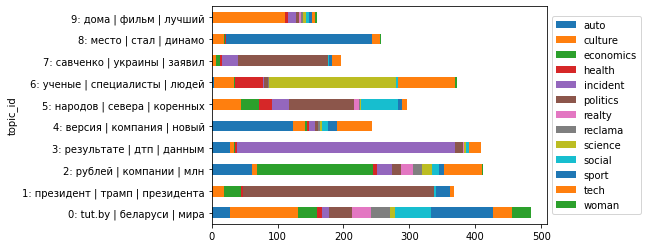

In [19]:
( # распределение количества текстов по темам с долями меток
topic_tags
.plot.barh(stacked=True) #,rot=0)
.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
)

---

In [20]:
data['keywords'] = data['topic_id'].map(topics)
data.sample(4)

,text,tag,topic_id,keywords
2004,"Канадский боксер Бермейн Стиверн заявил, что планирует нокаутировать россиянина Александра Поветкина в первой половине предстоящего боя за звание временного чемпиона мира по версии Всемирного боксерского совета (WBC) в супертяжелом весе, который состоится 17 декабря в Екатеринбурге.\n\n«Я планирую нокаутировать Поветкина, и чем раньше, тем лучше. Я отлично готов к бою, никаких проблем из-за смены часовых поясов у меня нет. Я очень серьезно настроен, прошел отличную подготовку и знаю, что победа будет моей.\n\nМои сильные стороны — удар, мощь, ими я и воспользуюсь», — передает слова боксера ТАСС.",sport,1,"[президент, трамп, президента]"
416,"Раскрыты личные траты Трампа на президентскую гонку\n\n9 декабря 2016 в 17:02\n\nLenta.ru\n\nИзбранный президент США Дональд Трамп потратил на свою избирательную кампанию 66 миллионов долларов из собственных средств. Такие данные, как передает Reuters, приводит Федеральная избирательная комиссия США.\n\nФото: Reuters\n\nВ целом же кампания стоила Трампу 322 миллиона долларов, в то время как его соперница Хиллари Клинтон потратила 565 миллионов.\n\nКак отмечается в сообщении агентства, в ходе праймериз миллиардер отказался финансировать опросы общественного мнения как «бесполезные». По данным компании mediaQuant, в начале 2016 года Трамп обошел 16 соперников внутри республиканской партии, активно используя бесплатные ресурсы в интернете и соцсетях, которые позволяли передавать каждое слово кандидата и обращаться напрямую к избирателям.\n\nВыборы президента США прошли 8 ноября. Инаугурация нового главы государства состоится 20 января 2017 года.",politics,1,"[президент, трамп, президента]"
1734,"Мировые цены на нефть снижаются\n\nТелеканал «Россия – Вологда»\n\nМировые цены на нефть пошли вниз после достижения максимальной отметки с июля 2015 года.Так, к девяти часам по мск стоимость февральских фьючерсов на «черное золото» марки Brent снизилась на 0,11% - до 55,63 доллара за бочку. А цена фьючерсов на нефть сорта WTI с поставкой в январе упала на 0,3% - до 52,67 доллара за баррель.",economics,2,"[рублей, компании, млн]"
1824,"Тегеран, , 10:59 — REGNUM Энергетическое сотрудничество России и Ирана как одних из влиятельнейших игроков на нефтяном рынке набирает обороты. В понедельник, 12 декабря, стороны подписали меморандум о совместной работе в области нефти и энергетики. Документ состоит из 23 пунктов, среди которых положения о разведке, добыче, разработке месторождений, своповых операциях. Об этом сообщило агентство Shana.\n\nВ меморандуме есть пункты о сотрудничестве по доставке газа, проведению исследовательских работ. Иран и Россия также будут вместе работать в области технологий при производстве оборудования, необходимого для нефтяной промышленности. Подписали меморандум состоялось в Тегеране по итогам заседания рабочей энергетической группы обеих стран в присутствии заместителя министра энергетики России Кирилла Молодцова и замминистра нефти Ирана Амира Хосейна Замани-Ния.\n\nСегодня, 13 декабря, также компания «Газпром нефть» подписала соглашение с Иранской национальной нефтяной компанией (NIOC) о...",economics,2,"[рублей, компании, млн]"
